# **DNN - Homework 1.**
## Author: Tomasz Zając

# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [3]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

In [4]:
import numpy as np
from clearml import Logger
from typing import List

In [5]:
%load_ext memory_profiler

# Dataset loading


In [6]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-11-18 21:01:30--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.121.160, 16.182.42.112, 52.217.162.128, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.121.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  --.-KB/s    in 0.09s   

2024-11-18 21:01:30 (121 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [7]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

Shapes:

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


Let's see some example images:

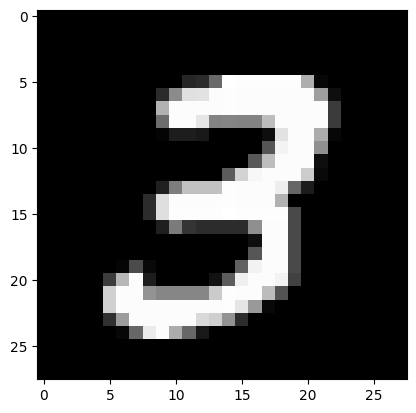

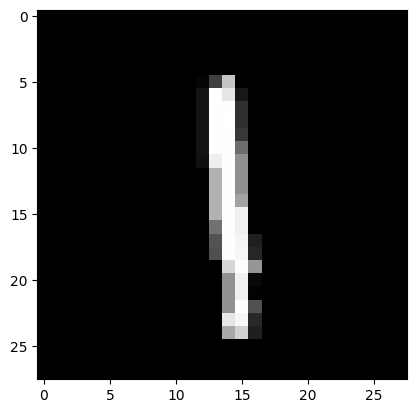

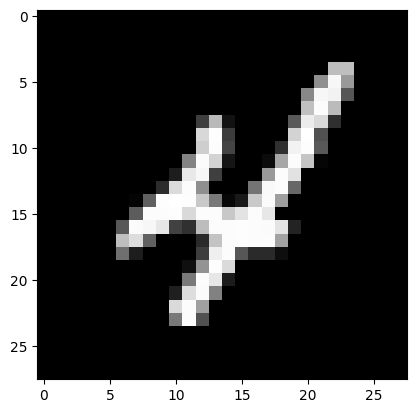

In [9]:
import matplotlib.pyplot as plt
for i in range (7, 10):
  example = x_train[i].reshape(28, 28)
  plt.imshow(example, cmap='gray')
  plt.show()

# ClearML setup

In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=SI7PTXAO9G964PGXKJ5A0076K2M2FL
%env CLEARML_API_SECRET_KEY=Cl9RRgySf8R_NDiGWbzexPRpPxSZN_lT9PkOPRnUTpsY7guwD-AJ7-eqacBCRIAgY08

from clearml import Task

task = Task.init(task_name="Training loss comparison")

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=SI7PTXAO9G964PGXKJ5A0076K2M2FL
env: CLEARML_API_SECRET_KEY=Cl9RRgySf8R_NDiGWbzexPRpPxSZN_lT9PkOPRnUTpsY7guwD-AJ7-eqacBCRIAgY08
ClearML Task: created new task id=3f92848689f348ffb9c6bc929ea24030
ClearML results page: https://app.clear.ml/projects/f51337ab41c64359b63dd17717db5fef/experiments/3f92848689f348ffb9c6bc929ea24030/output/log


# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [10]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [11]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="Backprop Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="Backprop Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.1063, Loss: 18.957186551483506
Epoch: 1, Accuracy: 0.8103, Loss: 1.28167925481337
Epoch: 2, Accuracy: 0.8613, Loss: 0.6237174854129596


# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 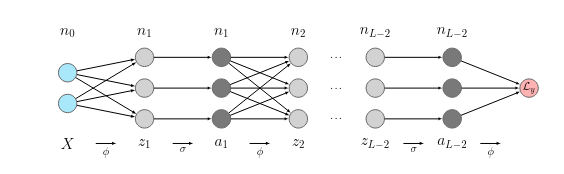)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 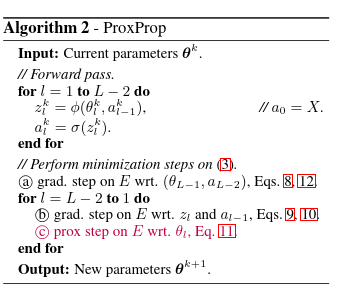)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 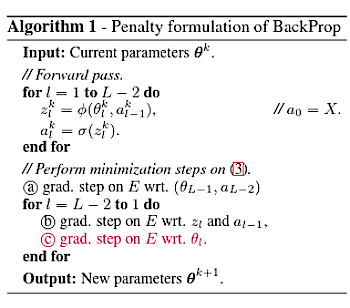)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

## Solution

A solution to the optimization problem above is $W$ that satisfies this equation:

$$
%\begin{equation}
\frac{\partial}{\partial W} \bigg( \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2 \bigg) = 0
%\end{equation}
$$

After differentiation:

$$
%\begin{equation}
\Big( W \cdot g^{(l-1)} + b^{(l)} - f_{\text{*}}^{(l)} \Big) \cdot \Big( g^{(l-1)} \Big)^{\text{T}} + \frac{1}{\eta} || W - W^{(l)} || = 0
%\end{equation}
$$

Now we can solve for $W$:

$$
%\begin{equation}
W = \bigg( \frac{1}{\eta} W^{(l)} + \Big( f_{\text{*}}^{(l)} - b^{(l)} \Big) \Big( g^{(l-1)} \Big)^{\text{T}} \bigg) \bigg( g^{(l-1)} \cdot \Big( g^{(l-1)} \Big)^{\text{T}} + \frac{1}{\eta}I \bigg)^{-1}
%\end{equation}
$$

This is actually the update of weights:

$$
%\begin{equation}
W^{(l)} := W
%\end{equation}
$$

Biases will be updated the same way as in standard backpropagation, using gradient descent:

$$
%\begin{equation}
b^{(l)} := b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
%\end{equation}
$$

From the chain rule we have:

$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
%\end{equation}
$$

which allows us to easily calculate biases' update using the value $\partial L / \partial f^{(l)}$.

In [12]:
def sigmoid_prime(z: np.ndarray) -> float:
    return sigmoid(z) * (1 - sigmoid(z))

In [13]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
        weights=None,
        biases=None
    ) -> None:
        # Important: use at least one layer of size a -> a
        # assert any(sizes[i] == sizes[i + 1] for i in range(len(sizes) - 1))

        self.sizes = sizes
        self.num_layers = len(sizes)

        if weights is not None:
          self.weights = weights
        else:
          self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

        if biases is not None:
          self.biases = biases
        else:
          self.biases = [np.random.randn(y, 1) for y in sizes[1:]]



    def feedforward(self, a: np.ndarray) -> np.ndarray:
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a


    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        # 1. Forward pass
        g = x
        gs = []
        fs = []

        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)

        # Calculate loss:
        loss = logloss(gs[-1], y)

        # 2. Backward pass
        dLdfs = []
        f_stars = []

        dLdg = self.cost_derivative(gs[-1], y)
        g_star = gs[-1] - eta * dLdg

        for l in range(self.num_layers - 2, -1, -1):
          dLdf = np.multiply(dLdg, np.multiply(gs[l], 1 - gs[l]))
          dLdfs.append(dLdf)
          f_star = fs[l] - np.multiply(sigmoid_prime(fs[l]), gs[l] - g_star)
          f_stars.append(f_star)
          if l != 0:
            dLdg = np.matmul(self.weights[l].T, dLdf)
            g_star = gs[l - 1] - np.matmul(self.weights[l].T, fs[l] - f_star)

        dLdfs.reverse()
        f_stars.reverse()

        # 3. Forward pass & updates
        for l in range(self.num_layers - 1):
          g_prev = x
          if l > 0:
            g_prev = gs[l - 1]

          # Biases (using GD):
          dLdb = np.mean(dLdfs[l], axis=1, keepdims=True)
          self.biases[l] -= eta * dLdb

          # Weights (using ProxProp):
          A = np.dot(f_stars[l] - self.biases[l], g_prev.T) + (1 / eta) * self.weights[l]
          B = np.dot(g_prev, g_prev.T) + (1 / eta) * np.eye(g_prev.shape[0])
          self.weights[l] = np.dot(A, np.linalg.inv(B))

        return loss


    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)


    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y


    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="ProxyProp Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="ProxyProp Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (
                x_train.shape[0] // mini_batch_size
            )  # we compute the average of the losses over the number of minibatches



# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.0957, Loss: 3.894247006965076
Epoch: 1, Accuracy: 0.8619, Loss: 0.7542866181307867
Epoch: 2, Accuracy: 0.9013, Loss: 0.43744919143130884


# Parameters exploration

In [ ]:
mini_batch_sizes = [80, 125, 200]
etas = [3.0, 4.0, 5.0]
for mini_batch_size in mini_batch_sizes:
    for eta in etas:
        network = ProxProp([784, 30, 30, 10])
        print(f"Results for mini_batch_size = {mini_batch_size}, eta = {eta}")
        network.SGD(
            (x_train, y_train),
            epochs=3,
            mini_batch_size=mini_batch_size,
            eta=eta,
            test_data=(x_test, y_test),
        )

Results for mini_batch_size = 80, eta = 3.0
Epoch: 0, Accuracy: 0.0935, Loss: 13.782751679415972
Epoch: 1, Accuracy: 0.8683, Loss: 0.9847513467311184
Epoch: 2, Accuracy: 0.9046, Loss: 0.4231335214504057
Epoch: 3, Accuracy: 0.9159, Loss: 0.3425966447345232
Results for mini_batch_size = 80, eta = 4.0
Epoch: 0, Accuracy: 0.1205, Loss: 17.50481385882988
Epoch: 1, Accuracy: 0.8854, Loss: 0.8892388296612729
Epoch: 2, Accuracy: 0.9146, Loss: 0.39724584288666187
Epoch: 3, Accuracy: 0.9207, Loss: 0.3253943289407264
Results for mini_batch_size = 80, eta = 5.0
Epoch: 0, Accuracy: 0.1272, Loss: 9.919220431510478
Epoch: 1, Accuracy: 0.8928, Loss: 0.6411835377651653
Epoch: 2, Accuracy: 0.9158, Loss: 0.36576956651803844
Epoch: 3, Accuracy: 0.9235, Loss: 0.31790644604747503
Results for mini_batch_size = 125, eta = 3.0
Epoch: 0, Accuracy: 0.1097, Loss: 22.581935837290082
Epoch: 1, Accuracy: 0.8491, Loss: 0.9819611490450125
Epoch: 2, Accuracy: 0.8947, Loss: 0.4593592988068702
Epoch: 3, Accuracy: 0.9064,

In [ ]:
mini_batch_sizes = [50, 75, 100]
etas = [4.0, 4.5, 5.0]
for mini_batch_size in mini_batch_sizes:
    for eta in etas:
        network = ProxProp([784, 30, 30, 10])
        print(f"Results for mini_batch_size = {mini_batch_size}, eta = {eta}")
        network.SGD(
            (x_train, y_train),
            epochs=3,
            mini_batch_size=mini_batch_size,
            eta=eta,
            test_data=(x_test, y_test),
        )

Results for mini_batch_size = 50, eta = 4.0
Epoch: 0, Accuracy: 0.0899, Loss: 5.9156159318637025
Epoch: 1, Accuracy: 0.879, Loss: 0.6820741822396811
Epoch: 2, Accuracy: 0.9101, Loss: 0.42854165399619387
Epoch: 3, Accuracy: 0.9211, Loss: 0.3670331825445055
Results for mini_batch_size = 50, eta = 4.5
Epoch: 0, Accuracy: 0.0855, Loss: 7.376382005502429
Epoch: 1, Accuracy: 0.8886, Loss: 0.7090242263382792
Epoch: 2, Accuracy: 0.9119, Loss: 0.4416230121095175
Epoch: 3, Accuracy: 0.9203, Loss: 0.3691032833214445
Results for mini_batch_size = 50, eta = 5.0
Epoch: 0, Accuracy: 0.1126, Loss: 11.593876833142449
Epoch: 1, Accuracy: 0.8861, Loss: 0.869579371934131
Epoch: 2, Accuracy: 0.9106, Loss: 0.436320446505241
Epoch: 3, Accuracy: 0.9194, Loss: 0.3844222288872859
Results for mini_batch_size = 75, eta = 4.0
Epoch: 0, Accuracy: 0.1187, Loss: 8.784157574313546
Epoch: 1, Accuracy: 0.887, Loss: 0.6601763865778465
Epoch: 2, Accuracy: 0.9119, Loss: 0.37663397953211614
Epoch: 3, Accuracy: 0.9188, Loss:

# Train the network

Training a network using the parameters that performed best in the experiments above turned out to work good, but not with 94% accuracy. Eta was chosen based on experiments above; further tests (on the fly) revealed that much smaller mini-batch sizes work better.

In [25]:
network = Network([784, 30, 30, 10])

In [32]:
import copy
weights = copy.deepcopy(network.weights)
biases = copy.deepcopy(network.biases)

In [33]:
def train_proxprop_network():
  proxprop_network = ProxProp([784, 30, 30, 10], weights, biases)
  proxprop_network.SGD(
    (x_train, y_train),
    epochs=15,
    mini_batch_size=30,
    eta=4.5,
    test_data=(x_test, y_test),
    logger=task.get_logger(),
  )

In [20]:
mem_usage_proxprop = memory_usage((train_proxprop_network,), interval=1.0)

Epoch: 0, Accuracy: 0.1137, Loss: 2.6685851664161877
Epoch: 1, Accuracy: 0.8894, Loss: 0.6979835024370312
Epoch: 2, Accuracy: 0.912, Loss: 0.4561042082476495
Epoch: 3, Accuracy: 0.92, Loss: 0.41477877502767124
Epoch: 4, Accuracy: 0.9253, Loss: 0.39891716684806855
Epoch: 5, Accuracy: 0.9287, Loss: 0.3621529385523459
Epoch: 6, Accuracy: 0.9305, Loss: 0.34692471618766413
Epoch: 7, Accuracy: 0.9332, Loss: 0.3380689205303847
Epoch: 8, Accuracy: 0.9367, Loss: 0.33036711894322424
Epoch: 9, Accuracy: 0.9378, Loss: 0.31120368204898635
Epoch: 10, Accuracy: 0.9393, Loss: 0.2938830606131472
Epoch: 11, Accuracy: 0.9367, Loss: 0.2969473110350527
Epoch: 12, Accuracy: 0.9381, Loss: 0.29266843208317916
Epoch: 13, Accuracy: 0.9368, Loss: 0.2908527615210469
Epoch: 14, Accuracy: 0.9372, Loss: 0.28936579691590214
Epoch: 15, Accuracy: 0.9379, Loss: 0.29181898914439847


In [26]:
def train_network():
  network.SGD(
    (x_train, y_train),
    epochs=15,
    mini_batch_size=30,
    eta=4.5,
    test_data=(x_test, y_test),
    logger=task.get_logger(),
  )

In [27]:
mem_usage_network = memory_usage((train_network,), interval=1.0)

Epoch: 0, Accuracy: 0.0692, Loss: 5.0733906642238855
Epoch: 1, Accuracy: 0.892, Loss: 0.794412434963171
Epoch: 2, Accuracy: 0.9144, Loss: 0.3972762267306447
Epoch: 3, Accuracy: 0.9235, Loss: 0.3381331000697801
Epoch: 4, Accuracy: 0.927, Loss: 0.3058209941573783
Epoch: 5, Accuracy: 0.934, Loss: 0.28673045645725664
Epoch: 6, Accuracy: 0.9338, Loss: 0.2717087268694575
Epoch: 7, Accuracy: 0.9373, Loss: 0.25918115085323673
Epoch: 8, Accuracy: 0.9368, Loss: 0.24958665333916868
Epoch: 9, Accuracy: 0.9389, Loss: 0.24000359085816275
Epoch: 10, Accuracy: 0.9388, Loss: 0.23175477414174422
Epoch: 11, Accuracy: 0.939, Loss: 0.22515938606454966
Epoch: 12, Accuracy: 0.9401, Loss: 0.21818086957988733
Epoch: 13, Accuracy: 0.9389, Loss: 0.21480795597403024
Epoch: 14, Accuracy: 0.9401, Loss: 0.2099210721759375
Epoch: 15, Accuracy: 0.942, Loss: 0.2086134799782647


# Training plots for the best training

## ProxProp:

Training ProxProp network for small mini-batch sizes took a long time, these are the best results:

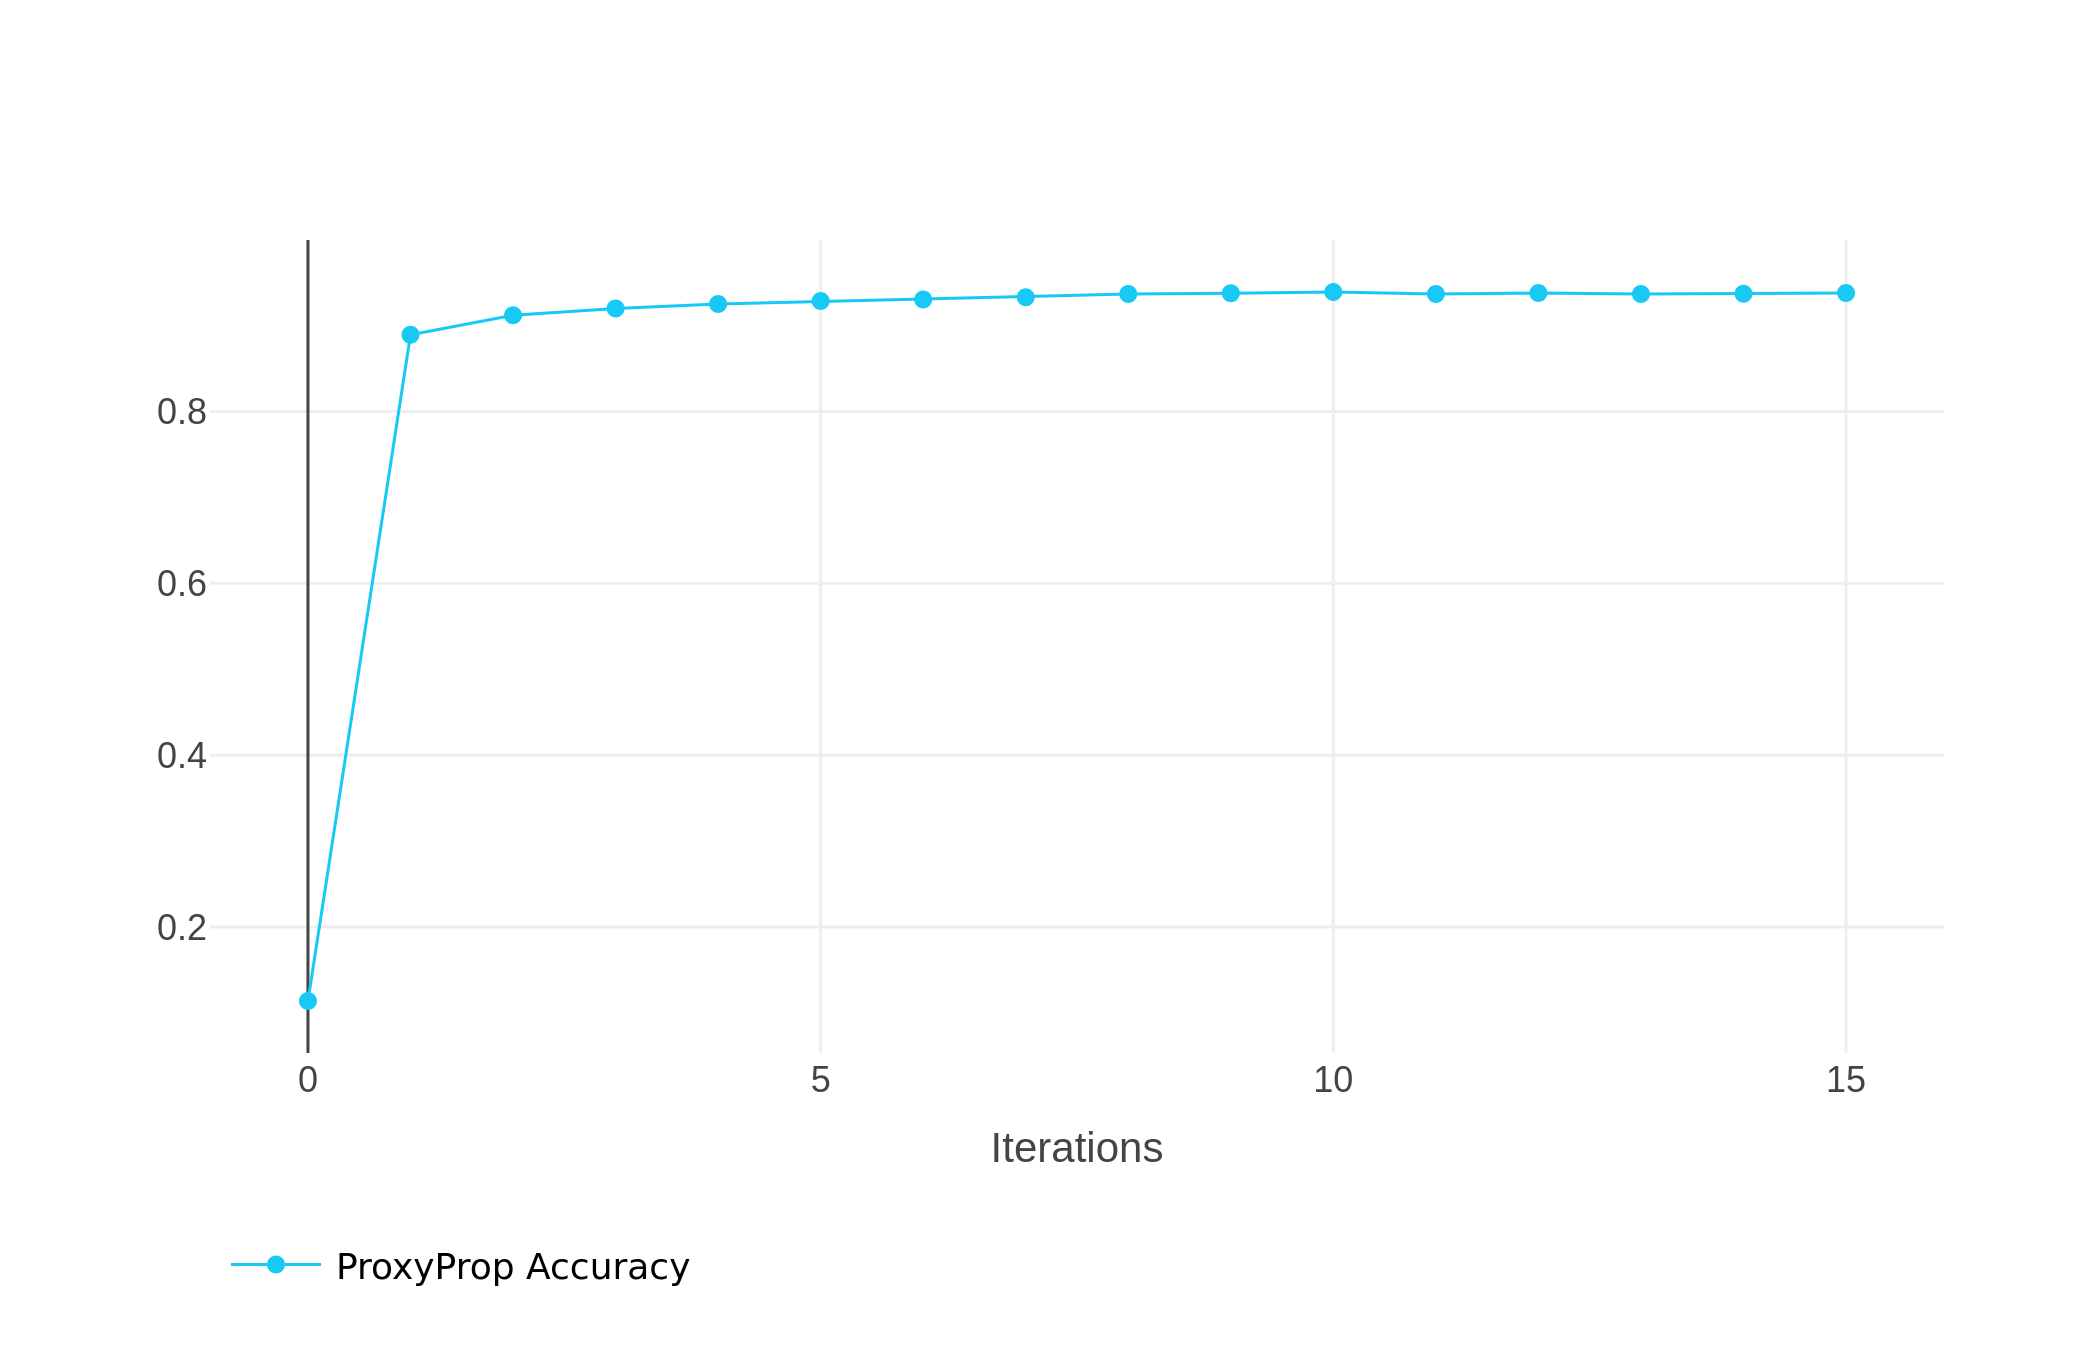

In iteration 10 there was the best accuracy - 0.9393. It was close to 94% - I guess for even smaller mini-batches the network could achieve it, but it would take longer to train it.

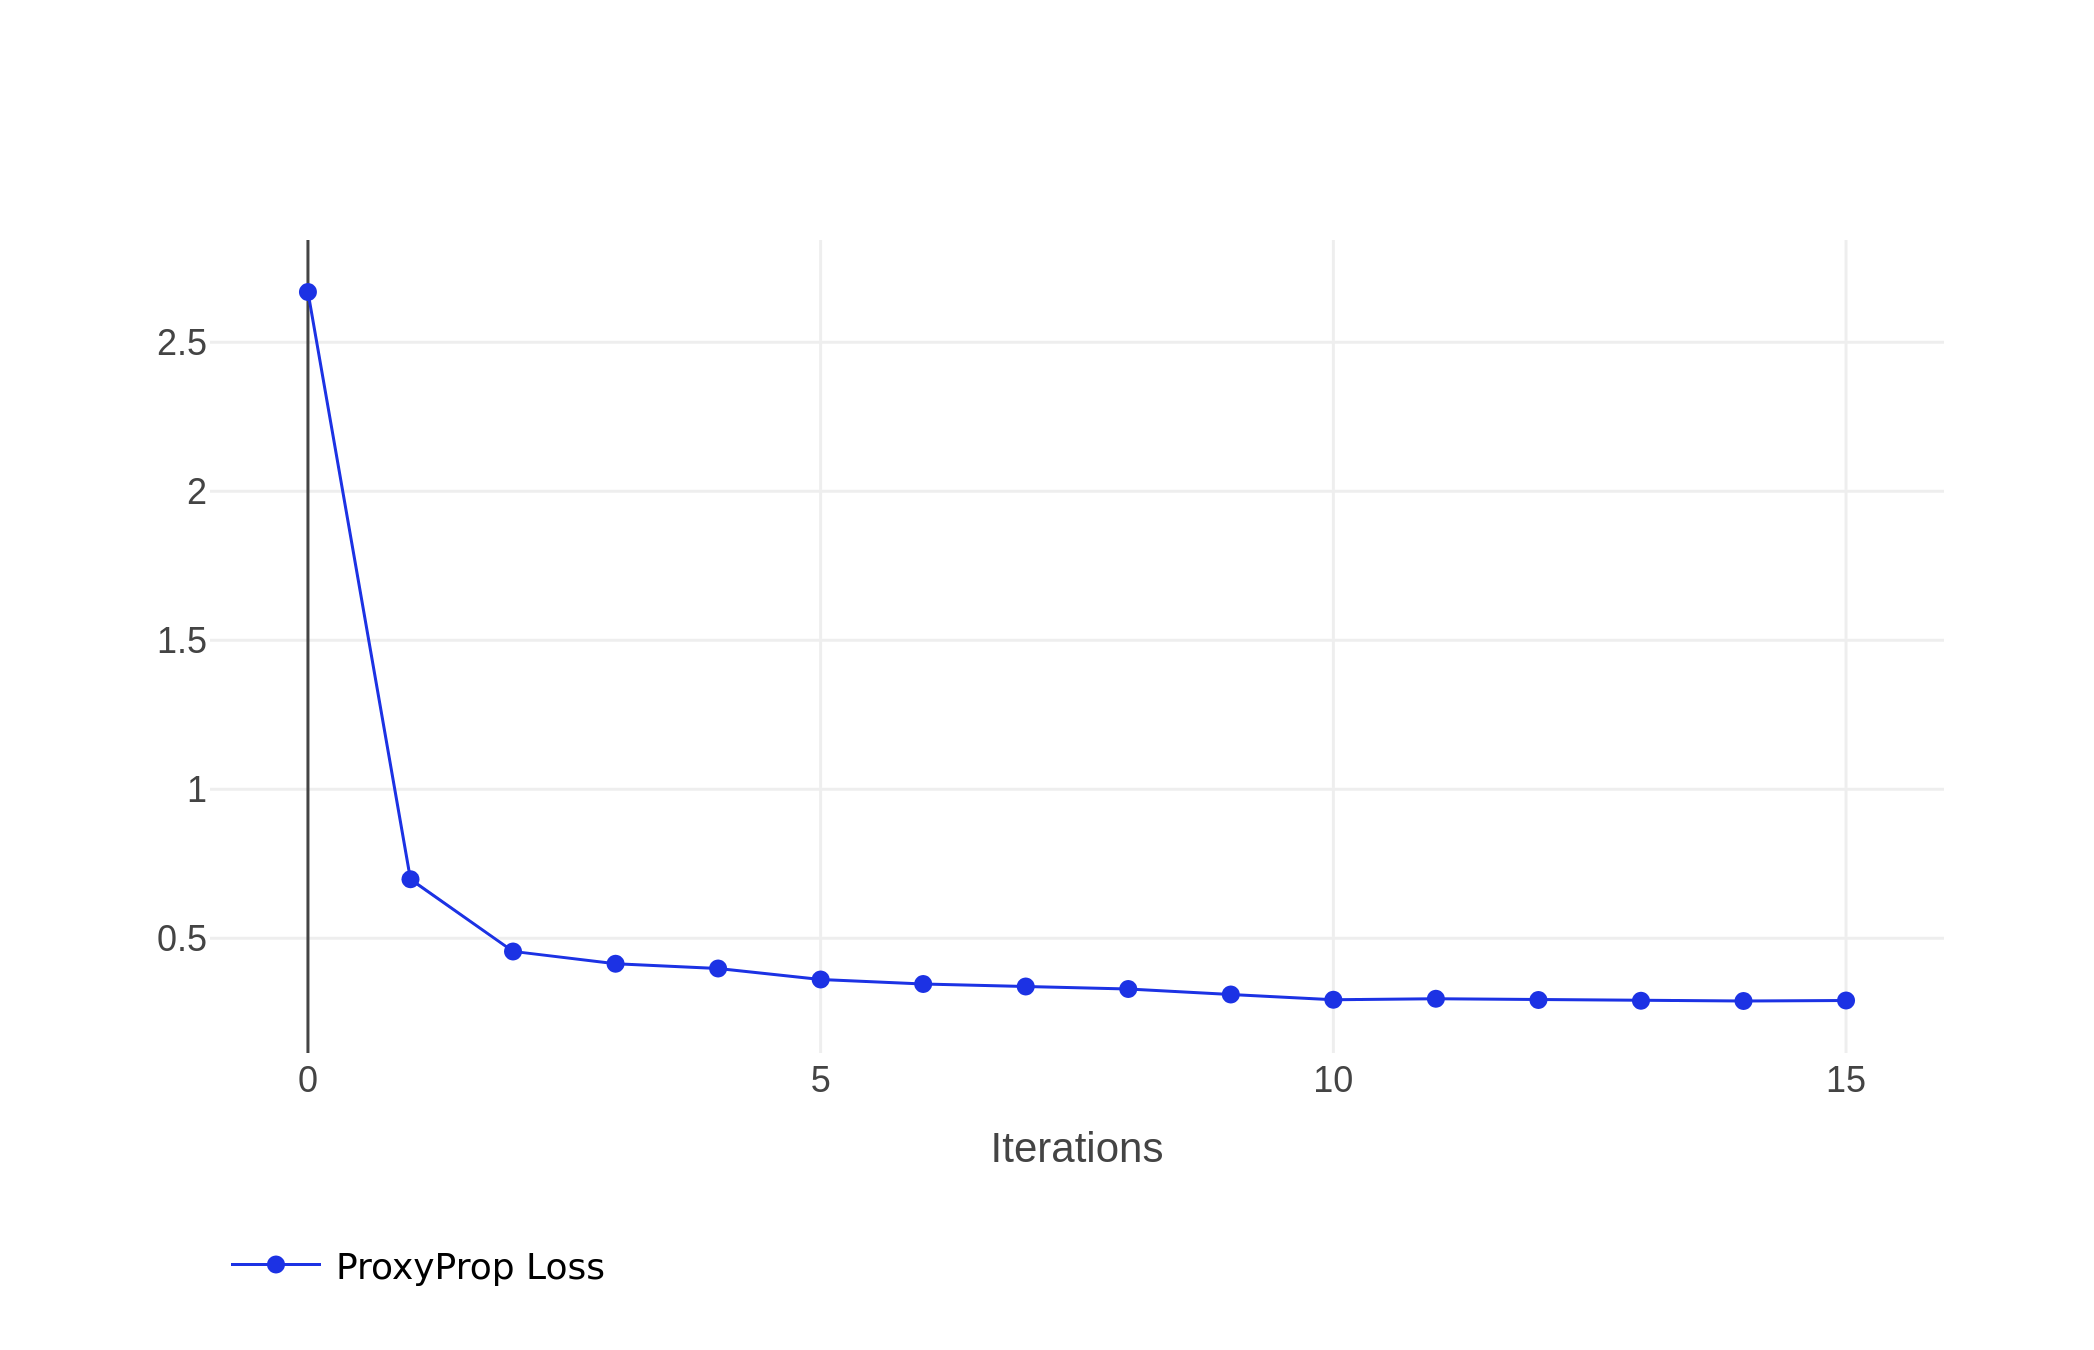

# Both methods compared:

Original backpropagation algorithm performed better here, it achieved 94%+ accuracy, finished executing much faster (40 min vs 31 s) and used a tiny fraction of memory needed by ProxProp method. The differences aren't visible here well, but there are training statistics above.

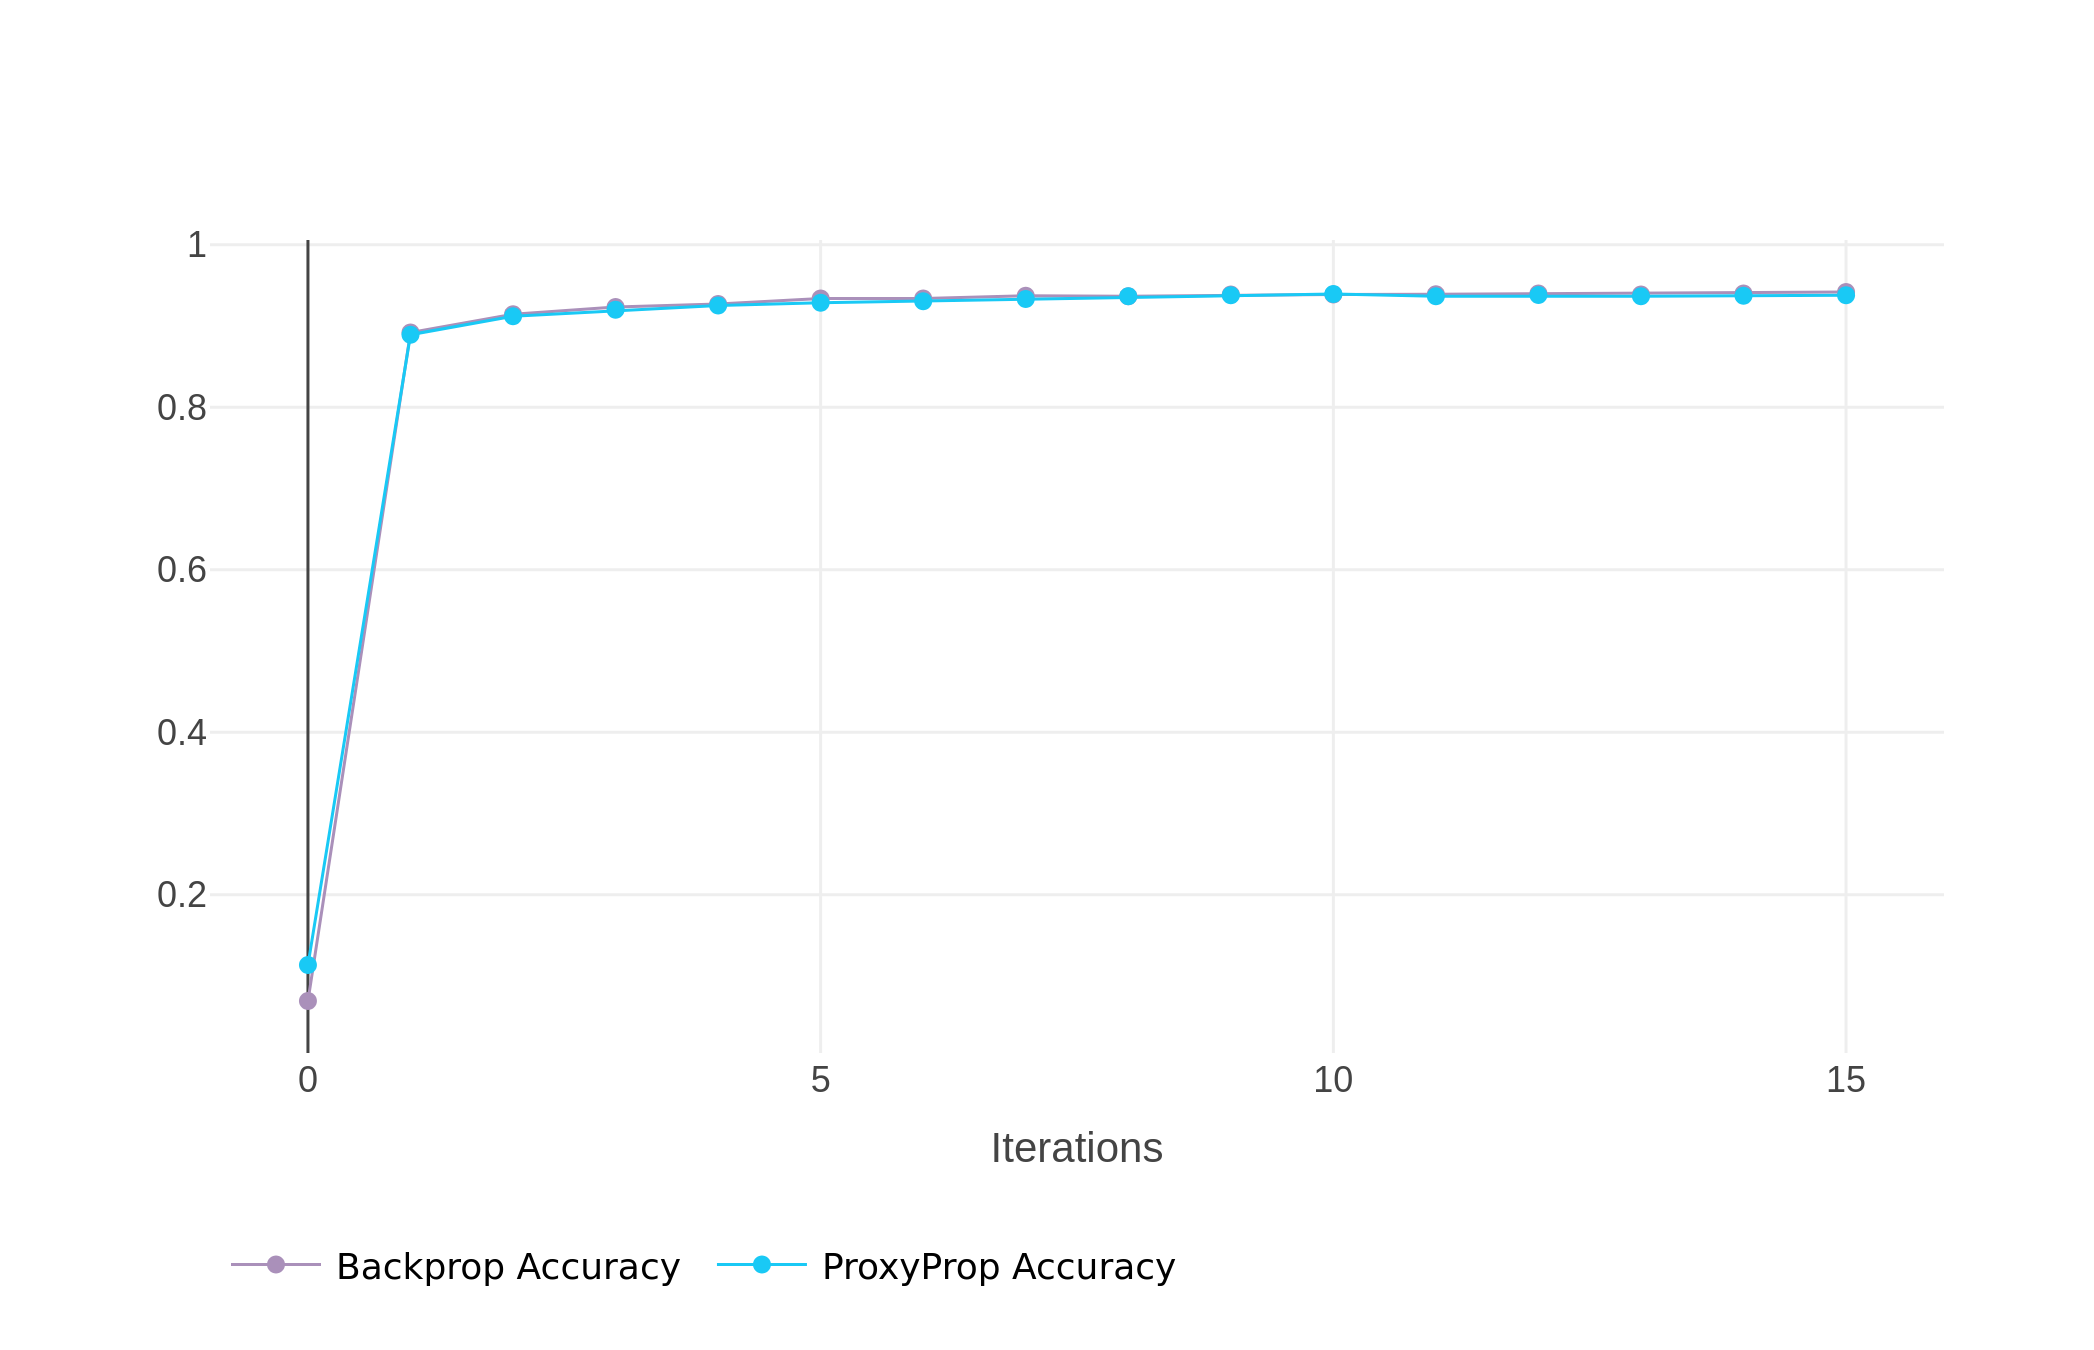

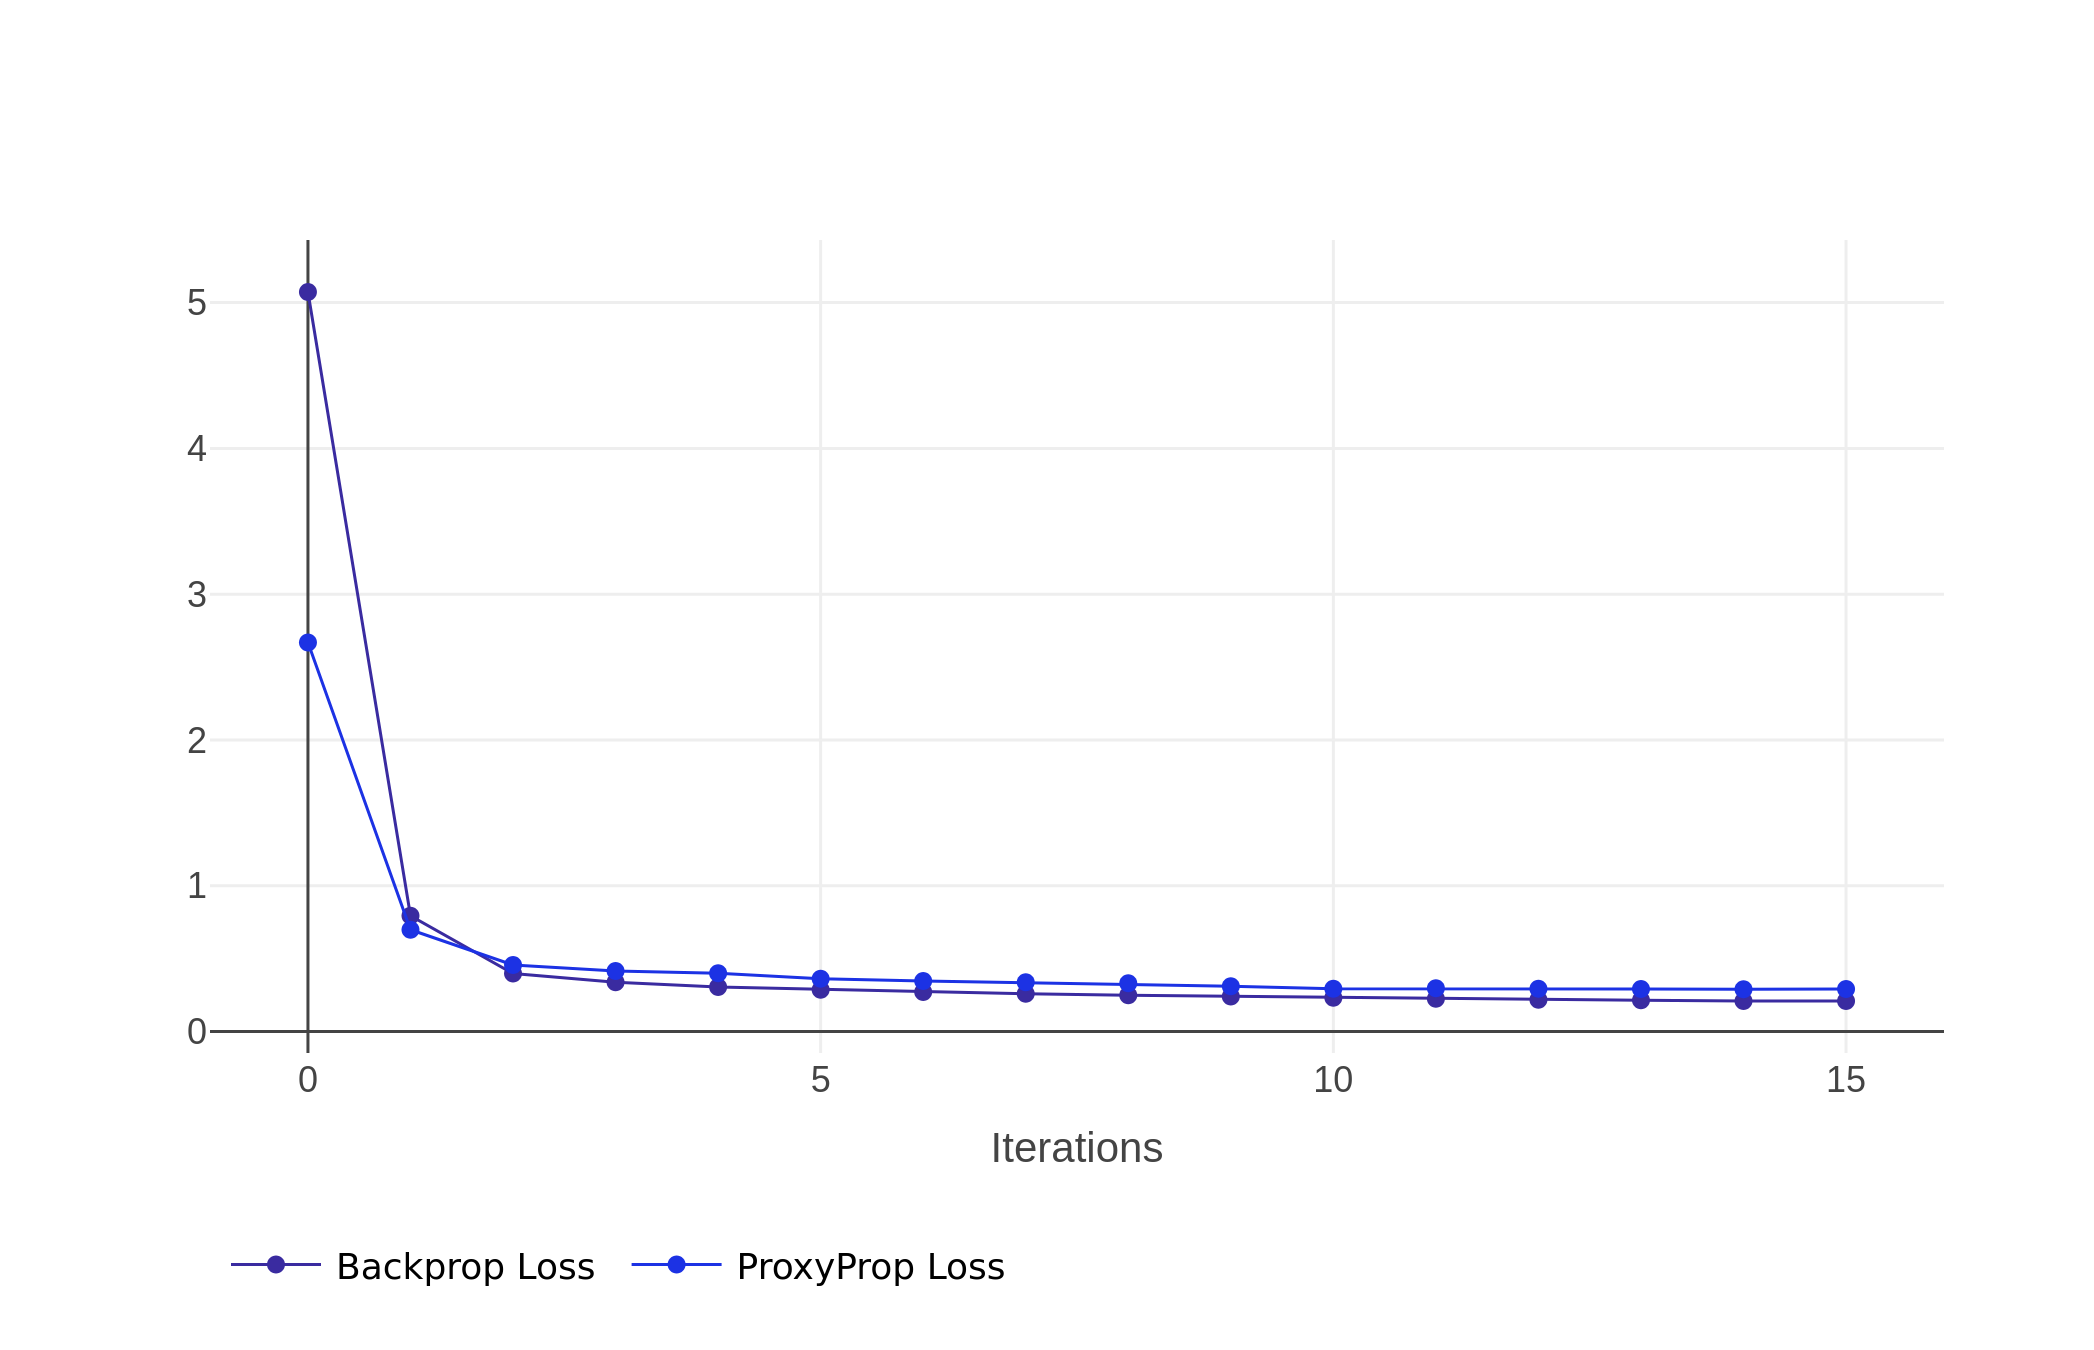

# Compare memory usage

In [17]:
from memory_profiler import profile
from memory_profiler import memory_usage

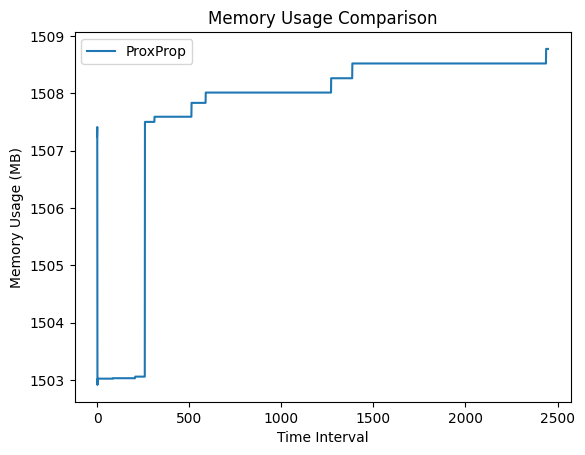

In [30]:
import matplotlib.pyplot as plt

plt.plot(mem_usage_proxprop, label='ProxProp')
plt.xlabel('Time Interval')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison')
plt.legend()
plt.show()


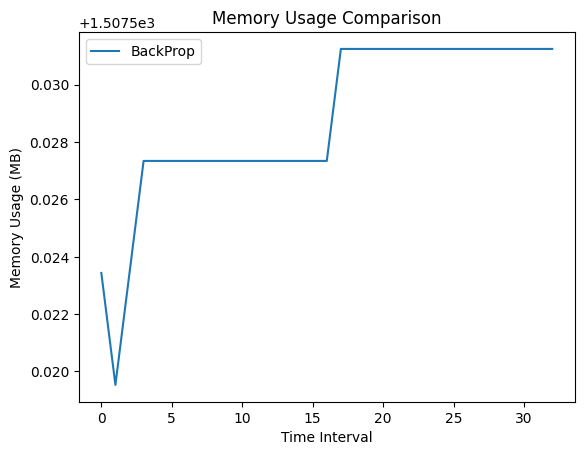

In [29]:
plt.plot(mem_usage_network, label='BackProp')
plt.xlabel('Time Interval')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison')
plt.legend()
plt.show()

# Memory usage plots (in case they disappear):

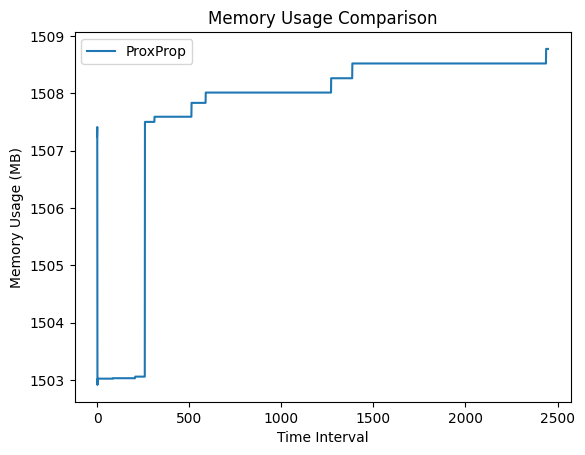

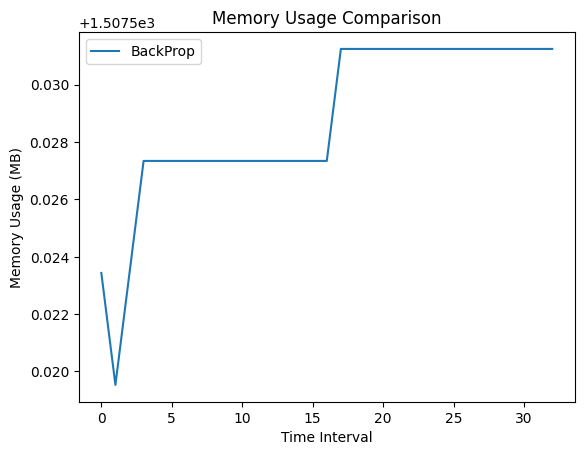